# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import warnings

from collections import defaultdict

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV

## Linear Model
from sklearn.linear_model import LogisticRegression

## Bayesian Modelling
from sklearn.naive_bayes import ComplementNB, MultinomialNB

## Tree-based Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Nearest-Neighbour Modelling
from sklearn.neighbors import KNeighborsClassifier

### Support Vector Machines
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix, recall_score

from scipy.stats import uniform


warnings.filterwarnings('ignore')

# Reading in Data

In [2]:
df = pd.read_csv("./data/clean_health - clean_health.csv")
df.head()

,papaId,createdAt,eventType,DeviceID,MessageID,Payload,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,packet_loss,is_lost
0,OWL_HQ,2022-03-12 00:00:10.228,health,IRDUCK01,UV16,Counter:58 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,58,0,-3.0,-3.0,1.0,0
1,OWL_HQ,2022-03-12 00:01:47.498,health,HEALTHDK,DE1R,Counter:61 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,61,0,-3.0,-3.0,2.0,1
2,OWL_HQ,2022-03-12 00:02:10.415,health,IRDUCK01,6T9P,Counter:59 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,59,0,-3.0,-3.0,1.0,0
3,OWL_HQ,2022-03-12 00:03:47.629,health,HEALTHDK,UVR4,Counter:62 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,62,0,-3.0,-3.0,1.0,0
4,OWL_HQ,2022-03-12 00:05:47.495,health,HEALTHDK,DVI7,Counter:63 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,63,0,-3.0,-3.0,1.0,0


In [3]:
print(f"Number of records in the data: {df.shape[0]}")
print(f"Number of attributes in the data: {df.shape[1]}")

Number of records in the data: 92451
Number of attributes in the data: 18


# Exploratory Data Analysis

## 1. Percentage of Missing Data

In [4]:
pd.DataFrame((df.isna().sum()/df.isna().count()) * 100, columns=['percent_miss']).sort_values(by='percent_miss', ascending=False)

,percent_miss
path,100.0
papaId,0.0
corrupted_message,0.0
packet_loss,0.0
board_temp,0.0
volts,0.0
full,0.0
counter,0.0
charging,0.0
corrupted_device,0.0


There are no missing data except for 'path'. Path was a feature that is not being used for CDPv3, that is why it is empty.

## 2. Number of Unique 'eventTypes'

In [5]:
print(f"Number of unique eventTypes: {df['eventType'].nunique()}")
print(f"Unique EventTypes: {df['eventType'].unique().tolist()}")

Number of unique eventTypes: 1
Unique EventTypes: ['health']


We are looking only at health of the network which is the 'health' eventType.

## 3. Number of Unique DeviceID

In [6]:
print(f"Number of unique DeviceIDs: {df['DeviceID'].nunique()}")
print(f"Unique DeviceIDs: {df['DeviceID'].unique().tolist()}")

Number of unique DeviceIDs: 2
Unique DeviceIDs: ['IRDUCK01', 'HEALTHDK']


## 4. Distribution of Hops

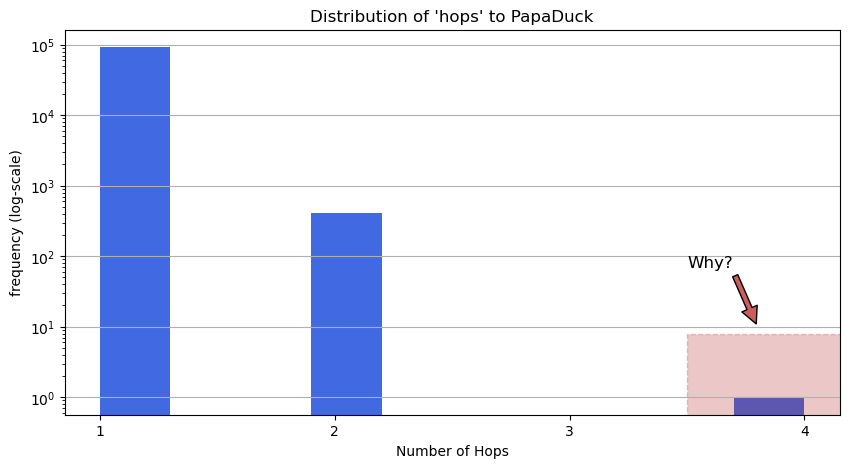

In [8]:
# Creating the plot
ax = df['hops'].plot(kind="hist", title="Distribution of 'hops' to PapaDuck", 
                                    color="royalblue", grid=True, figsize=(10, 5))

# Setting the axes
ax.grid(visible=False, which='major', axis='x')
ax.set_yscale('log')
ax.set_ylabel('frequency (log-scale)')
ax.set_xlabel('Number of Hops')
plt.xticks([1, 2, 3, 4])

# Creating a rectangle
rect = plt.Rectangle((3.5, 0), 4, 8, alpha=.25, color="firebrick", linestyle="--")
plt.gca().add_patch(rect)
ax.annotate('Why?', (3.8, 10), xytext=(3.5, 70), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)

# Showing the plot
plt.show()

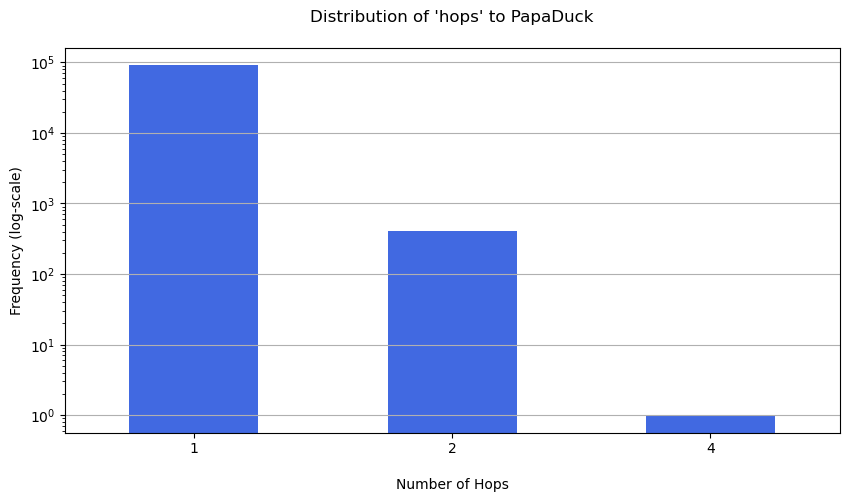

In [23]:
hops = df['hops'].value_counts()

ax = hops.plot(
    kind="bar", 
    title="Distribution of 'hops' to PapaDuck\n", 
    color="royalblue", 
    grid=True, 
    figsize=(10, 5)
)

# Setting the x label
ax.set_xlabel("\nNumber of Hops")
plt.xticks(rotation=360)
# plt.xticks([1, 2, 3, 4])

# Setting the y-axis
ax.grid(visible=False, which='major', axis='x')
ax.set_yscale('log')
ax.set_ylabel('Frequency (log-scale)')

# Identifying possible outlier
# rect = plt.Rectangle((2.5, 0), 3, 8, alpha=.25, color="firebrick", linestyle="--")
# plt.gca().add_patch(rect)
ax.annotate('Why?', (2.8, 10), xytext=(1, 70), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)

plt.show()

## 5. Number of Unique 'duckType'

In [18]:
print(f"Number of unique duckType: {df['duckType'].nunique()}")
print(f"Unique duckTypes: {df['duckType'].unique().tolist()}")

Number of unique duckType: 2
Unique duckTypes: [2, 98]


There is only 2-3 duckTypes: 1, 2, 3. 98 must be an error.

## 6. Distribution of "corrupted_device"

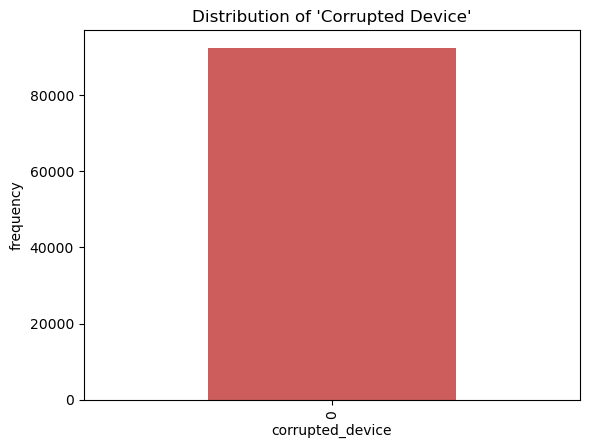

In [24]:
df.groupby('corrupted_device').size().plot(kind="bar", title="Distribution of 'Corrupted Device'", color="indianred")
plt.ylabel("frequency")
plt.show()

## 7. Distribution of "corrupted_message"

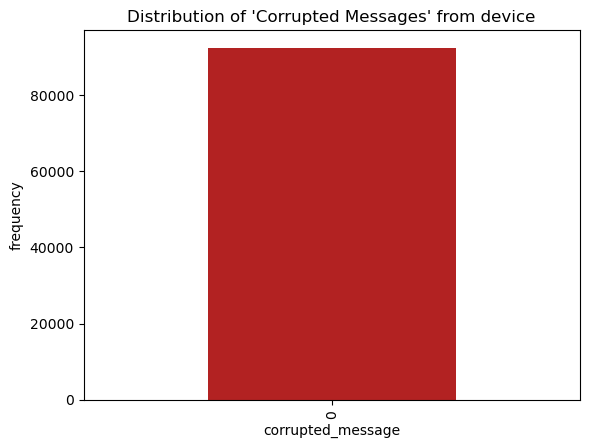

In [25]:
df.groupby('corrupted_message').size().plot(kind="bar", title="Distribution of 'Corrupted Messages' from device", color="firebrick")
plt.ylabel('frequency')
plt.show()

## 8. Distribution of Charging

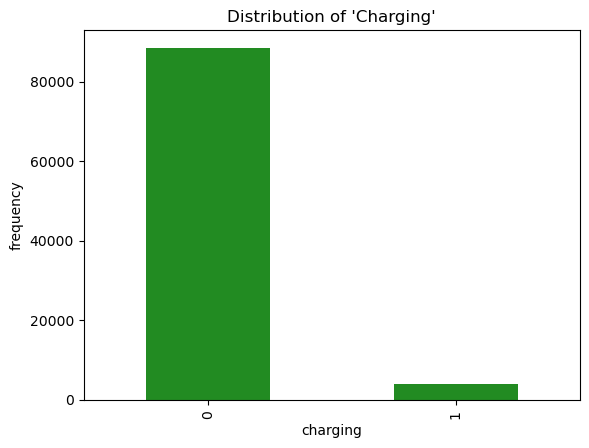

In [26]:
df.groupby('charging').size().plot(kind="bar", title="Distribution of 'Charging'", color="forestgreen")
plt.ylabel("frequency")
plt.show()

## 9. Distribution of Counter

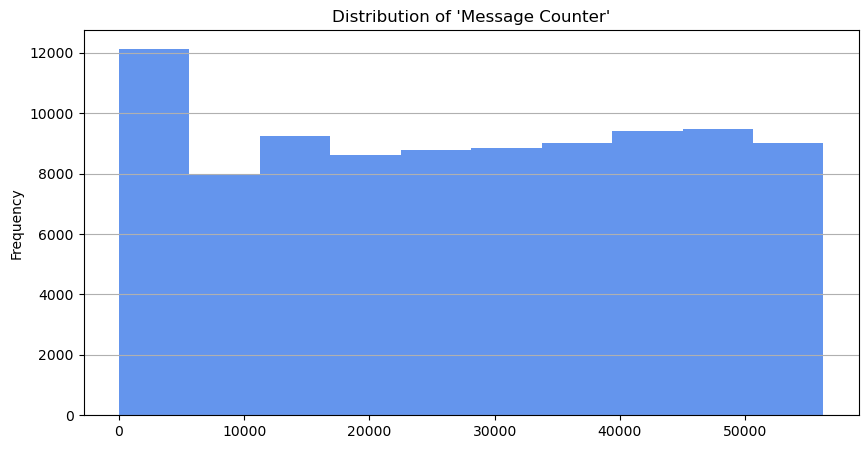

In [27]:
ax = df['counter'].plot(kind="hist", title="Distribution of 'Message Counter'",
                   figsize=(10, 5), color="cornflowerblue", grid=True)

ax.grid(visible=False, which='major', axis="x")
plt.show()

## 10. Distribution of Fully-Charged Devices

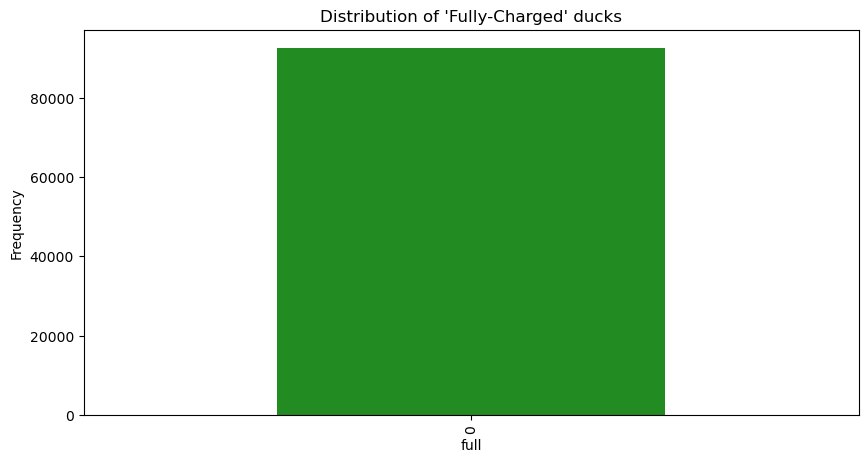

In [28]:
df.groupby('full').size().plot(kind="bar", color="forestgreen", figsize=(10, 5),
                              title="Distribution of 'Fully-Charged' ducks")
plt.ylabel("Frequency")
plt.show()

## 11. Distribution of Volts

There are some volts that are -3 which probably indicated that the sensor was not operating properly. To plot this, might be good to remove those -3 values (But for visualization only. This can be an indicator for packet loss)

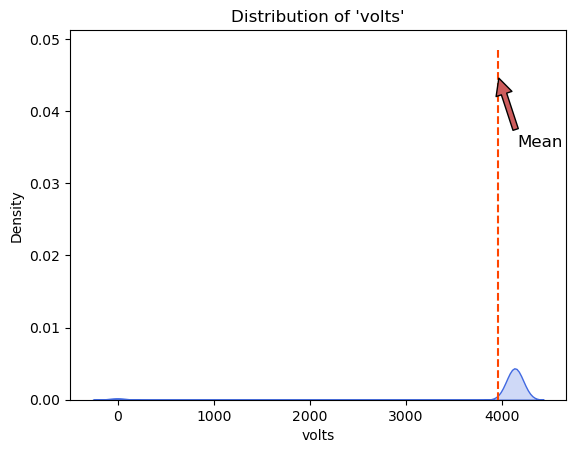

In [29]:
ax = sns.kdeplot(x="volts", data=df, fill=True, color="royalblue")
ax.set_title("Distribution of 'volts'")
ax.vlines(df['volts'].mean(), ymin=0, ymax=0.0488, linestyle="--", color="orangered")
ax.annotate('Mean', (df['volts'].mean(), 0.045), xytext=(4160, 0.035), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 12. Distribution of Board Temperature

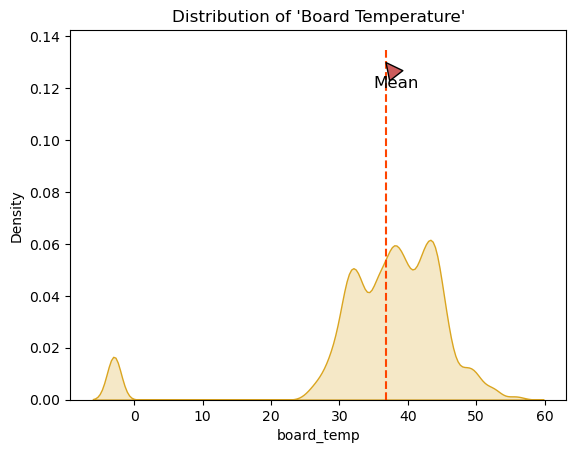

In [30]:
ax = sns.kdeplot(x="board_temp", data=df, fill=True, color="goldenrod")
ax.set_title("Distribution of 'Board Temperature'")
ax.vlines(df['board_temp'].mean(), ymin=0, ymax=0.1355, linestyle="--", color="orangered")
ax.annotate('Mean', (df['board_temp'].mean(), 0.13), xytext=(35, 0.12), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 13. Distribution of Packet-Loss

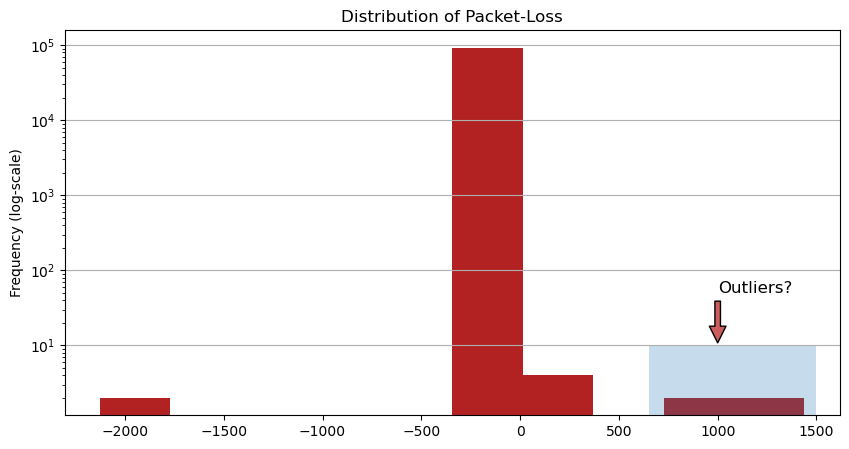

In [31]:
ax = df['packet_loss'].plot(kind="hist", color="firebrick", 
                            figsize=(10, 5), title="Distribution of Packet-Loss", grid=True)
ax.grid(visible=False, which="major", axis="x")
ax.set_yscale('log')
ax.set_ylabel('Frequency (log-scale)')
rect = plt.Rectangle((650, 0), 850, 10, linestyle="--", alpha=0.25)
plt.gca().add_patch(rect)
ax.annotate("Outliers?", (1000, 10), xytext=(1000, 50), arrowprops=dict(facecolor="indianred", shrink=0.05), fontsize=12)
plt.show()

## 14. Distribution of Target Variable

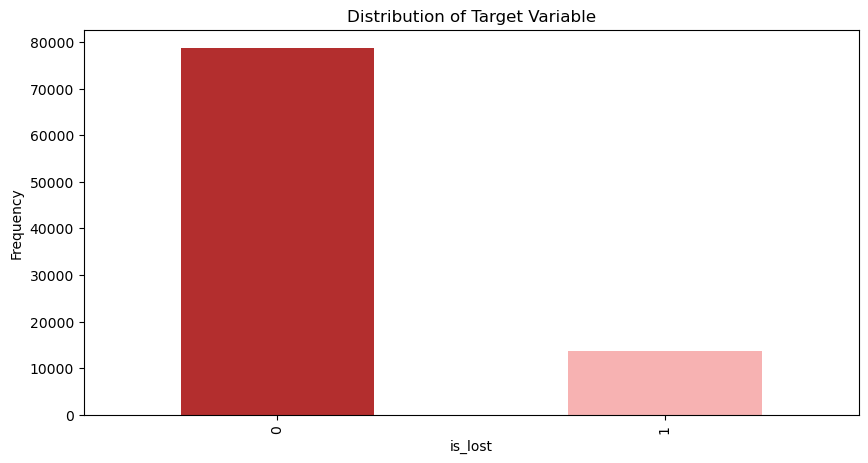

In [33]:
df.groupby('is_lost').size().plot(kind="bar", color=("#b32e2e", "#f7b2b2"), 
                                  title="Distribution of Target Variable", figsize=(10, 5))
plt.ylabel("Frequency")
plt.show()

# Observations from EDA

1. There is only **one** instance of `hops` that is $>3$.
2. KPIs such as `ducktype`, `corrupted_device`, `corrupted_message`, `charging` & `full` all have $0$ variation and therefore can be disregarded during data-modelling.
3. The distribution of `board_temp` almost follows a *Gaussian Distribution*.

# Data-Modeling

## Use DuckID as a feature

In [34]:
df['DeviceID'].value_counts()

IRDUCK01    46293
HEALTHDK    46158
Name: DeviceID, dtype: int64

In [35]:
# Dummifying the DeviceID column

df['is_IRDUCK01'] = df['DeviceID'].apply(lambda row: 1 if row == 'IRDUCK01' else 0)

In [36]:
df.head()

,papaId,createdAt,eventType,DeviceID,MessageID,Payload,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,packet_loss,is_lost,is_IRDUCK01
0,OWL_HQ,2022-03-12 00:00:10.228,health,IRDUCK01,UV16,Counter:58 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,58,0,-3.0,-3.0,1.0,0,1
1,OWL_HQ,2022-03-12 00:01:47.498,health,HEALTHDK,DE1R,Counter:61 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,61,0,-3.0,-3.0,2.0,1,0
2,OWL_HQ,2022-03-12 00:02:10.415,health,IRDUCK01,6T9P,Counter:59 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,59,0,-3.0,-3.0,1.0,0,1
3,OWL_HQ,2022-03-12 00:03:47.629,health,HEALTHDK,UVR4,Counter:62 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,62,0,-3.0,-3.0,1.0,0,0
4,OWL_HQ,2022-03-12 00:05:47.495,health,HEALTHDK,DVI7,Counter:63 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,63,0,-3.0,-3.0,1.0,0,0


In [37]:
kpis = ['is_IRDUCK01', 'hops', 'counter', 'volts', 'board_temp', 'is_lost', 'charging']
df_new = df[kpis]
df_new.head()

,is_IRDUCK01,hops,counter,volts,board_temp,is_lost,charging
0,1,1,58,-3.0,-3.0,0,1
1,0,1,61,-3.0,-3.0,1,1
2,1,1,59,-3.0,-3.0,0,1
3,0,1,62,-3.0,-3.0,0,1
4,0,1,63,-3.0,-3.0,0,1


In [38]:
df_train, df_test = train_test_split(
    df_new, 
    test_size=.20, 
    random_state=42, 
    shuffle=True, 
    stratify=df_new['is_lost']
)
print(f"Shape of the Training Dataset : {df_train.shape}")
print(f"Shape of the Test Dataset : {df_test.shape}")

Shape of the Training Dataset : (73960, 7)
Shape of the Test Dataset : (18491, 7)


In [39]:
# Splitting features and target

X_train, y_train = df_train.drop('is_lost', axis=1).values, df_train['is_lost'].values
X_test, y_test = df_test.drop('is_lost', axis=1).values, df_test['is_lost'].values

In [40]:
def conf_visualizer(y_true:np.array, y_pred:np.array, labels:list) -> None:
    """ Function to pretty print the Confusion Matrix """
    
    grp = ["True Neg", "False Pos", "False Neg", "True Pos"]
    cf = confusion_matrix(y_true, y_pred, labels=labels)
    
    grp_cnts = [f"{cnt}" for cnt in cf.flatten()]
    grp_percent = [f"{val*100:.4f}%" for val in cf.flatten()/np.sum(cf)]
    
    
    annotations = [f"{x1}\n{x2}\n{x3}" for x1, x2, x3 in zip(grp, grp_cnts, grp_percent)]
    annotations = np.array(annotations).reshape(2, 2)
    
    plt.figure(figsize=(10, 5))
    plt.title("Confusion Matrix")
    sns.heatmap(cf, annot=annotations, cmap="Reds", fmt="")
    plt.ylabel("True Labels")
    plt.xlabel("Predictions")
    plt.show()

## 1. Logistic Regression - BaseLine

### 1.1 : Best Parameters Search

In [41]:
logreg_search = RandomizedSearchCV(LogisticRegression(max_iter=10000), 
                                  dict(C=uniform(loc=0, scale=1), tol=[1e-4, 1e-3, 1e-2], 
                                       penalty=['l1', 'l2']), n_iter=100, n_jobs=-1, 
                                   cv=StratifiedKFold(shuffle=True), scoring='recall', random_state=42)

scaler = StandardScaler()
logreg_search.fit(scaler.fit_transform(X_train), y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=LogisticRegression(max_iter=10000), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1697d3b20>,
                                        'penalty': ['l1', 'l2'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='recall')

In [42]:
logreg_search.best_params_

{'C': 0.05808361216819946, 'penalty': 'l2', 'tol': 0.0001}

### 1.2 : Training on Best Parameters

In [43]:
logreg = LogisticRegression(random_state=42, max_iter=10000, n_jobs=-1, **logreg_search.best_params_)
scaler = StandardScaler()
logreg.fit(scaler.fit_transform(X_train), y_train)

print(classification_report(y_test, logreg.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, logreg.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, logreg.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     15738
           1       0.00      0.00      0.00      2753

    accuracy                           0.85     18491
   macro avg       0.43      0.50      0.46     18491
weighted avg       0.72      0.85      0.78     18491

F1-Score of the model : 0.0
Recall Score of the model : 0.0


### 1.3 : Confusion Matrix

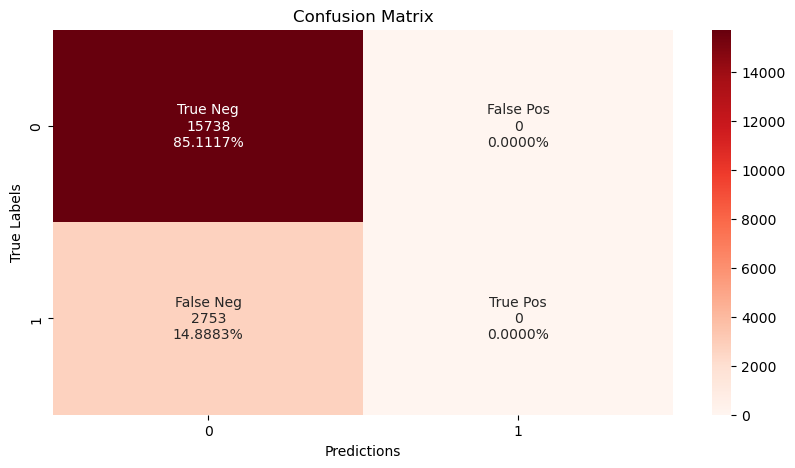

In [44]:
conf_visualizer(y_test, logreg.predict(scaler.transform(X_test)), logreg.classes_)

## 2. Naive Bayes

### 2.1 : Best Parameters Search

In [45]:
cbclf = ComplementNB()
cbclf_search = GridSearchCV(cbclf, dict(alpha=np.random.uniform(low=1e-1, high=10, size=100)), 
                            scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)
scaler = MinMaxScaler()
cbclf_search.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': array([1.14699876, 4.90400503, 4.049889  , 4.55494775, 5.48082283,
       9.01507341, 1.8773315 , 3.94231213, 8.82879231, 4.4395191 ,
       0.19262989, 3.35463706, 8.32264883, 4.23307322, 0.81061331,
       7.75603999, 6.70494194, 6.10615008, 3.78224833, 4.228605...
       0.96273249, 1.34748403, 6.45190043, 0.90107655, 2.48247668,
       5.24384885, 2.22210948, 5.28739771, 9.6583168 , 6.12334028,
       6.61851724, 3.1993663 , 6.00760322, 3.40376366, 9.66041369,
       7.5404299 , 1.23641803, 7.0796739 , 8.87892979, 0.72385251,
       7.71877065, 4.87941053, 9.93509979, 1.0480509 , 9.4291313 ,
       7.0728493 , 0.95198021, 2.40398131, 1.28554627, 0.47390047,
       0.91700887, 2.30380969, 6.64949827, 7.25625798, 5.81060861])},
             scoring='recall')

In [46]:
cbclf_search.best_params_

{'alpha': 1.1469987560862944}

### 2.2 : Training on Best Parameters

In [47]:
cbclf = ComplementNB(**cbclf_search.best_params_)
scaler = MinMaxScaler()
cbclf.fit(scaler.fit_transform(X_train), y_train)

print(classification_report(y_test, cbclf.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, cbclf.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, cbclf.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.91      0.05      0.10     15738
           1       0.15      0.97      0.26      2753

    accuracy                           0.19     18491
   macro avg       0.53      0.51      0.18     18491
weighted avg       0.80      0.19      0.12     18491

F1-Score of the model : 0.2630699685534591
Recall Score of the model : 0.9723937522702506


### 2.3 : Confusion Matrix

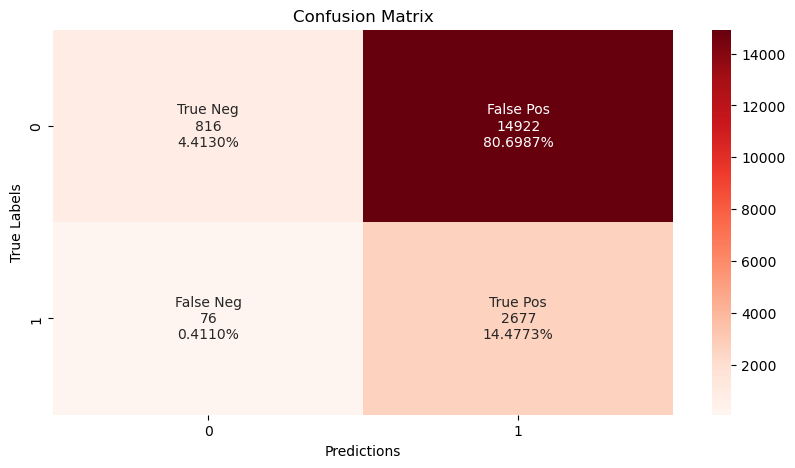

In [48]:
conf_visualizer(y_test, cbclf.predict(scaler.transform(X_test)), cbclf.classes_)

## 3. Decision Tree

### 3.1 : Best Parameter Search

In [49]:
dtree = DecisionTreeClassifier()
dtree_search = RandomizedSearchCV(dtree, 
                                  dict(ccp_alpha=np.random.uniform(low=0.0, high=1, size=100),
                                      class_weight=["balanced", "balanced_subsample"]),
                                 n_iter=1000,
                                 n_jobs=-1,
                                 cv=StratifiedKFold(shuffle=True), 
                                 scoring='recall')

dtree_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.18521815, 0.85625495, 0.90518674, 0.66632136, 0.17917131,
       0.99915042, 0.08711205, 0.05109808, 0.32755136, 0.67252283,
       0.55797367, 0.72413536, 0.672416  , 0.50943535, 0.74654341,
       0.9182713...
       0.1794512 , 0.31739996, 0.353802  , 0.7382479 , 0.42694549,
       0.38785192, 0.91496172, 0.87548968, 0.86566894, 0.38212875,
       0.03444115, 0.53238992, 0.5745223 , 0.34153104, 0.11103412,
       0.03802818, 0.06845565, 0.85187567, 0.3782687 , 0.32900192,
       0.78157445, 0.71357342, 0.98352098, 0.6297908 , 0.1546821 ,
       0.44455511, 0.9717151 , 0.67585395, 0.11232334, 0.98016326]),
                                        'class_weight': ['balanced',
                                                         'balanced_subsample']},
                   scoring='recall')

### 3.2 : Training on Best Parameters 

In [50]:
dtree_search.best_params_

{'class_weight': 'balanced', 'ccp_alpha': 0.18521814992500085}

In [51]:
dtree = DecisionTreeClassifier(random_state=42, **dtree_search.best_params_)
dtree.fit(X_train, y_train)

print(classification_report(y_test, dtree.predict(X_test), labels=dtree.classes_))
print(f"F1-Score of the model : {f1_score(y_test, dtree.predict(X_test))}")
print(f"Recall Score of the model : {recall_score(y_test, dtree.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15738
           1       0.15      1.00      0.26      2753

    accuracy                           0.15     18491
   macro avg       0.07      0.50      0.13     18491
weighted avg       0.02      0.15      0.04     18491

F1-Score of the model : 0.2591790623234796
Recall Score of the model : 1.0


### 3.3 : Confusion Matrix

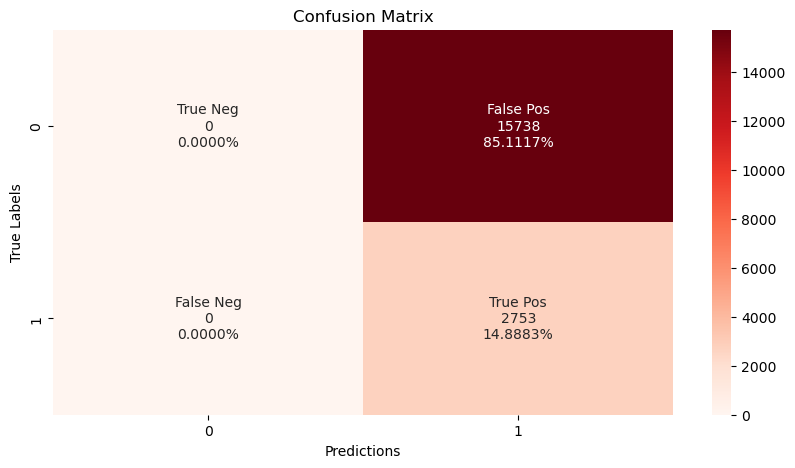

In [52]:
conf_visualizer(y_test, dtree.predict(X_test), dtree.classes_)

## 4. K-Nearest Neighbours

### 4.1 : Best Parameter Search

In [53]:
knn_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), dict(n_neighbors=[3, 5, 7, 9, 11, 21, 51, 101]), 
                          scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)

scaler = StandardScaler()
knn_search.fit(scaler.fit_transform(X_train), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 21, 51, 101]},
             scoring='recall')

### 4.2 : Training on Best Parameters

In [54]:
knn_search.best_params_

{'n_neighbors': 3}

In [55]:
knn = KNeighborsClassifier(n_jobs=-1, **knn_search.best_params_)
knn.fit(scaler.transform(X_train), y_train)

print(classification_report(y_test, knn.predict(scaler.transform(X_test)), labels=knn.classes_))
print(f"F1-Score of the model : {f1_score(y_test, knn.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, knn.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.86      0.93      0.89     15738
           1       0.24      0.12      0.16      2753

    accuracy                           0.81     18491
   macro avg       0.55      0.53      0.53     18491
weighted avg       0.77      0.81      0.78     18491

F1-Score of the model : 0.16395793499043976
Recall Score of the model : 0.12459135488557936


### 4.3 : Confusion Matrix

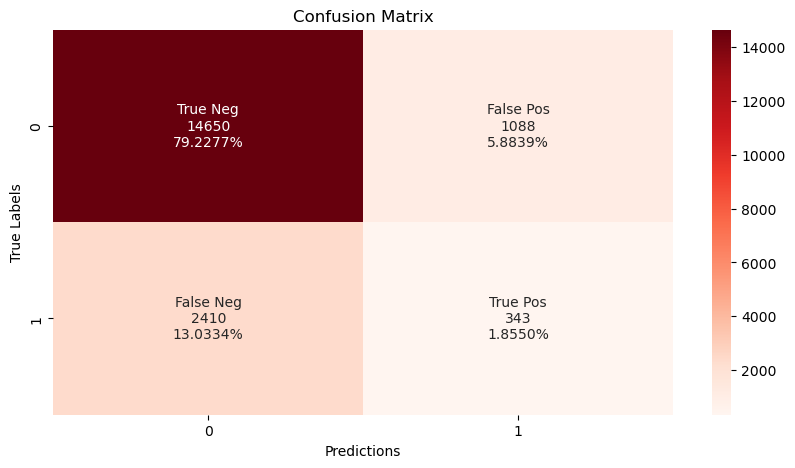

In [56]:
conf_visualizer(y_test, knn.predict(scaler.transform(X_test)), knn.classes_)

## 5. Support Vector Machine

### 5.1 : Best Parameter Search

In [57]:
svm_search = GridSearchCV(SVC(class_weight='balanced'), dict(C=np.random.uniform(low=0.01, high=10, size=100)), 
                          scoring='recall', cv=StratifiedKFold(shuffle=True), n_jobs=-1)

scaler = StandardScaler()
svm_search.fit(scaler.fit_transform(X_train), y_train)

KeyboardInterrupt: 

In [ ]:
svm_search.best_params_, svm_search.best_score_

({'C': 9.526327284185086}, 0.626891548449702)

### 5.2 : Training on Best Parameters

In [ ]:
svm = SVC(class_weight='balanced', **svm_search.best_params_)
svm.fit(scaler.transform(X_train), y_train)

print(classification_report(y_test, svm.predict(scaler.transform(X_test))))
print(f"F1-Score of the model : {f1_score(y_test, svm.predict(scaler.transform(X_test)))}")
print(f"Recall Score of the model : {recall_score(y_test, svm.predict(scaler.transform(X_test)))}")

              precision    recall  f1-score   support

           0       0.89      0.53      0.67      5625
           1       0.19      0.62      0.29      1006

    accuracy                           0.55      6631
   macro avg       0.54      0.58      0.48      6631
weighted avg       0.78      0.55      0.61      6631

F1-Score of the model : 0.294021101992966
Recall Score of the model : 0.6232604373757455


### 5.3 : Confusion Matrix

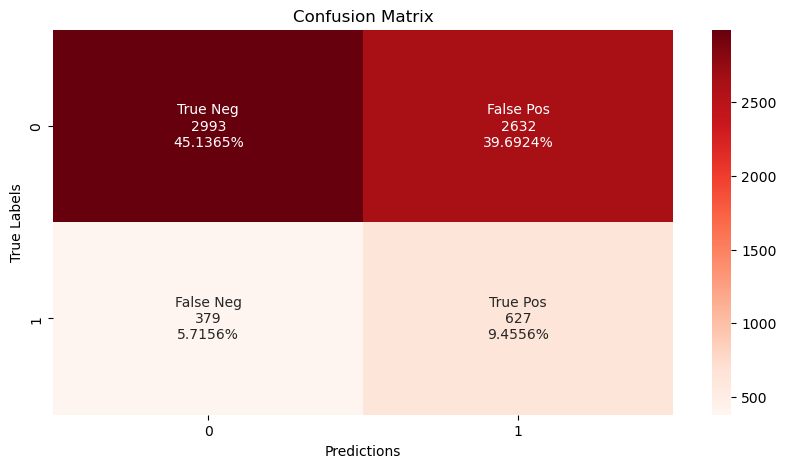

In [ ]:
conf_visualizer(y_test, svm.predict(scaler.transform(X_test)), svm.classes_)